# Project 1: Navigation

The goal of this project is train an agent to navigate and collect yellow bananas from Unity ML-Agents toolkit Bananas environment.

### Environment:

The environment is a large square world filled with yellow and blue bananas. The goal of the agent is to collect as many yellow bananas as possible while avoiding blue bananas. At every step the agent has access to the state of the environment. The size of the state space is 37. State observed by the agent is ray-based perception of objects around it's forward direction and its velocity.

The actions that agent can take at a point in time are one of move forward, move backward, turn left and turn right; so size of the action space is 4. If the agent collects a yellow banana it receives +1 reward and -1 reward for collecting blue banana. The task is episodic and in order to solve the environment, your agent must get an average score of +13 over 100 consecutive episodes.

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
%matplotlib inline

In [2]:
env = UnityEnvironment(file_name="Banana.app")
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


In [4]:
def plot_scores(scores):
    """ Helper function for plotting the score at the end
    """
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores)
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.show()

In [5]:
# this is imporvement on the practice code provided by the instructor
from solution.double_dqn_agent import Agent, LR
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

### Approach

Agent is trained using Deep Reinforcement algorithm Double Deep Q-Learning. In the next sections I will talk about the Double Q-Learning.

#### Q-Learning

<img src="submission/docs/images/env_agent_interaction_q_table.png" style="width:400px;height:200px;">

$Q$-Learning is a basic Reinforcement learning techinique. It is simple and easy to implement, especially if our states are discrete and the state space is small. To start with the agent provides random actions as input to the environment and bulids a table which eventually helps it in making the right decisions. The table is called as a Q table. Each row in the table has information about a unique state and its corresponding action Q-value pairs, for all possible actions when the vehicle is in that state. The Q values are values that are learned by the agent from the feedback provided by the environment. The agent first looks at all the action Q value pairs for that state, then chooses the action with highest Q value and sends it to the vehicle. The vehicle then sends back a reward and next state so that the agent can update the Q value for the action in the table. The equation for updating the Q value is given by

\begin{equation}
 Q(s_{t},a_{t}) := Q(s_{t},a_{t}) + \alpha(R_{t+1} + \gamma\max_{a\in A}Q(s_{t+1},a) - Q(s_{t},a_{t})) 
\label{q-learning-rule}
\end{equation}

Where   
  $Q$ is $Q$ function,  
  $R_{t+1}$ is reward received,   
  $\alpha$ is Learning rate,      
  $\gamma$ is Discount factor,  
  $s_{t}$ is current state,  
  $s_{t+1}$ is future state,  
  $a_{t}$ is current action,  
  $a$ is action. 

#### Deep Q-Network (DQN)

In  Q-Learning the intelligence acquired by the agent is stored in the form of a table. This approach is not scalable and is only good for learning environment which has smaller state space. To make it scalable a tabular value functio can be replaced by $Q(s_{t},a_{t};\theta_{t})$, a parameterized value function (neural network), can be used.

<img src="submission/docs/images/env_agent_interaction_q_netwrok.png" style="width:400px;height:200px;"> 

The parameters can be updated by the following rule

\begin{equation}
 \theta_{t+1} = \theta_{t} + \alpha(Y^{Q}_{t} - Q(s_{t},a_{t};\theta_{t})) 
\label{q-learning-rule-basic}
\end{equation}

\begin{equation}
    Y^{Q}_{t} = R_{t+1} + \gamma\max_{a}Q(s_{t+1},a;\theta_{t})
\label{target}
\end{equation}

Where   
  $Q(s_{t},a_{t};\theta_{t})$ is a parameterized value function,  
  $\theta_{t}$ is current parameters of value function,  
  $R$ is reward received,   
  $\alpha$ is Learning rate,      
  $\gamma$ is Discount factor,  
  $s_{t}$ is current state,  
  $s_{t+1}$ is future state,  
  $a_{t}$ is current action,  
  $a$ is action. 

To make the network more stable Mnih et al. (2015) proposed using a seperate target network from the online network for updating the parameters. In practice target network, $\theta^{-}_{t}$, is a delayed snapshot of online network. Here is the updated target.

\begin{equation}
    Y^{Q}_{t} = R_{t+1} + \gamma\max_{a}Q(s_{t+1},a;\theta^{-}_{t})
\label{target-new}
\end{equation}


**Replay Memory**  
In practice, DQN algorithm stores the last N experience tuples in the replay memory, and samples uniformly at random from the memory when performing updates. This approach is in some respects limited because the memory buffer does not differentiate important transitions and always overwrites with recent transitions owing to the finite memory size N. Similarly, the uniform sampling gives equal importance to all transitions in the replay memory.A more sophisticated sampling strategy might emphasize transitions from which we can learn the most, similar to prioritized sweeping.[1]

#### Double DQN
The max operator in standard Q-learning and DQN uses the same values both to select and to evaluate an action. This makes it more likely to select overestimated values, resulting in overoptimistic value estimates. Decoupling the selection from the evaluation will fix this. This is the idea behind Double Q-learning [3]. In [2] van Hasselt et al extend the same for DQN.

\begin{equation}
    Y^{DoubleQ}_{t} = R_{t+1} + \gamma\max_{a}Q(s_{t+1},a;\theta^{'}_{t})
\label{target-double-basic}
\end{equation}

This looks similar to our updated target network equation from DQN. Instead of creating a new network, van Hasselt et al in [2], suggest using $Q(s_{t+1},a;\theta_{t})$ from DQN for selection. Here is updated Double DQN target function

\begin{equation}
    Y^{DoubleQ}_{t} = R_{t+1} + \gamma Q(s_{t+1},{argmax}_{a} Q(s_{t+1},a;\theta_{t});\theta^{-}_{t})
\label{target-double}
\end{equation}

Update equation for double DQN parameter value function is 

\begin{equation}
 \theta_{t+1} = \theta_{t} + \alpha(R_{t+1} + \gamma Q(s_{t+1},{argmax}_{a} Q(s_{t+1},a;\theta_{t});\theta^{-}_{t}) - Q(s_{t},a_{t};\theta_{t})) 
\label{doubledqn-update-rule}
\end{equation}

#### Model Architecture
For the parameterized value function I used the following architecture where FC is a Fully connected layer and ReLu is a Rectified Linear Unit

\begin{equation}
    [State]_{(1\times37)}  \longrightarrow [FC]_{(37\times64)} \longrightarrow [ReLu] \longrightarrow [FC]_{(64\times64)} \longrightarrow [ReLu] \longrightarrow [FC]_{(64\times4)} \longrightarrow [ActionValues]_{(1\times4)}
\label{model}
\end{equation}

#### Hyperparameters

|Parameter|Description|Value|
|:---:|:---:|:---:|
|Buffer size|Size of the replay memory|100000|
|Batch size|Size of the mini batches|64|
|$\gamma$|Discount factor|0.99|
|$\alpha$|Learning Rate|0.00025|
|Update frequency|How often to update the network|4|
|Initial $\epsilon$| Initial exploration factor|1.0|
|Final $\epsilon$| Final exploration factor|0.01|
|$\epsilon$ decay| Rate at which \epsilon decays |0.995|

One modification over the actual DQN implementation is instead of copying the online network into target network after every n steps, we update the target network slowly after every step.

** some componenets of the report are taken from my own project [4]

## Training the model

Episode 100	Average Score: 0.53
Episode 200	Average Score: 3.55
Episode 300	Average Score: 7.29
Episode 400	Average Score: 11.05
Episode 500	Average Score: 12.75
Episode 600	Average Score: 13.77
Episode 700	Average Score: 15.22
Episode 800	Average Score: 13.50
Episode 900	Average Score: 14.20
Episode 1000	Average Score: 14.23


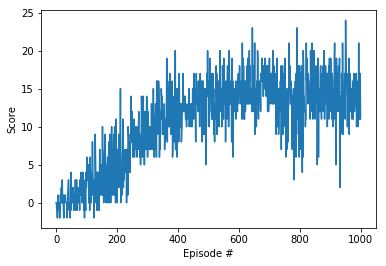

In [6]:
def doubledqn(n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Double Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    best_score = 13.0
    eps = eps_start                    # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action_theta, action = agent.act(state, eps)
            #next_state, reward, done, _ = env.step(action)
            
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            
            agent.step(state, action, action_theta, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window)>= best_score*1.1 : # save the weights if the rolling mean increased more than 10% 
            best_score = np.mean(scores_window)
            torch.save(agent.qnetwork_local.state_dict(), 'double_dqn_checkpoint.pth')

    return scores

scores = doubledqn()
plot_scores(scores)

## Running the model

In [8]:
# load the weights from file
agent.qnetwork_local.load_state_dict(torch.load('dqn_checkpoint.pth'))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    _, action = agent.act(state)                   # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 16.0


### Conclusion

In this project I have implemented a Double DQN to build an agent which can play the Unity ML-Agents toolkit Bananas environment. The agent learns to complete the episode after 600 episodes. The agent consistently acheives a final reward of around 14.

### Future steps

- After a lot of experimentation I have observed that training the Double DQN for more than 1500 episodes deteriorates the performance of the network. I am not why this has happened, futher analysis need to be done.
- Explore if using other versions of DQN like the ones with Prioritized Experience Replay, Distributed DQN, Dueling DQN would import agent perforance or make it learn faster.



### References

[1] [Human-level control through deep reinforcement learning by Mnih et al.](https://www.nature.com/articles/nature14236)  
[2] [Deep Reinforcement Learning with Double Q-learning by van Hasselt et al.](https://arxiv.org/abs/1509.06461)  
[3] [Double Q-learning by van Hasselt et al.](https://papers.nips.cc/paper/3964-double-q-learning)
[4] [DQN-Atari-Pong submission](https://github.com/mmuppidi/DQN-Atari-Pong)